In [1]:
!python --version

Python 3.10.13


In [2]:
!pip install tensorflow==2.15.0 scipy==1.11.4 imbalanced-learn scikit-plot ipykernel numpy pandas scikit-learn seaborn matplotlib opencv-python opencv-python-headless wurlitzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import scikitplot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers

# Set TensorFlow logging level to ERROR
tf.get_logger().setLevel("ERROR")

2024-03-23 07:41:30.246892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 07:41:30.246992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 07:41:30.426432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

# Check if GPU is used by TensorFlow
print("GPU in use: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  2
TensorFlow Version:  2.15.0
GPU in use:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Read data

In [5]:
df = pd.read_csv('/kaggle/input/full-fullsize/breast-level_annotations.csv')
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
...,...,...,...,...,...,...,...,...,...,...
19995,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,training
19996,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,training
19997,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,training
19998,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training


In [6]:
df['image_path'] = '/kaggle/input/full-fullsize/png/png/' + df['study_id'] + '/' + df['image_id'] + '.png'
df['label'] = df['breast_birads'].map({'BI-RADS 1': '0',
                                       'BI-RADS 2': '0',
                                       'BI-RADS 3': '1',
                                       'BI-RADS 4': '1',
                                       'BI-RADS 5': '1'})

In [7]:
train_df = df[df['split'] == 'training']

tmp_test_df = df[df['split'] == 'test']
test_df, val_df = train_test_split(tmp_test_df, test_size=0.5, stratify=tmp_test_df['label'], random_state=42)

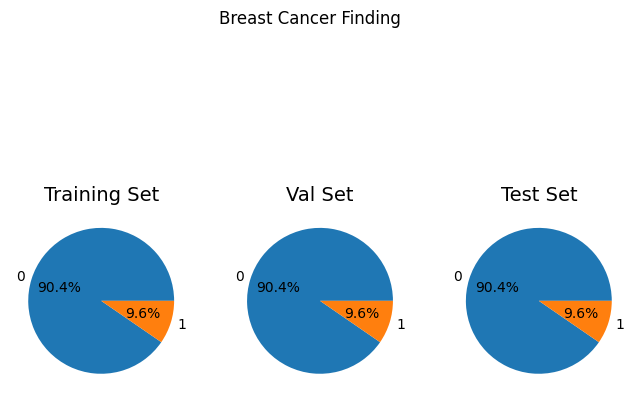

In [8]:
# label distributions
import matplotlib.pyplot as plt
value = train_df['label'].value_counts()
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
fig.suptitle('Breast Cancer Finding')
axs[0].pie(value, labels=value.index, autopct='%1.1f%%')
axs[0].set_title('Training Set', fontsize=14)

# label distributions
value_1 = val_df['label'].value_counts()
axs[1].pie(value_1, labels=value_1.index, autopct='%1.1f%%')
axs[1].set_title('Val Set', fontsize=14)

# label distributions
value_2 = test_df['label'].value_counts()
axs[2].pie(value_2, labels=value_2.index, autopct='%1.1f%%')
axs[2].set_title('Test Set', fontsize=14)

plt.show()

In [9]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors.
    '''

    color = 'rgb'
    img_size = (224, 224)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    tr_gen = ImageDataGenerator(rescale=1./255,
                                horizontal_flip=True,
                                vertical_flip=True,
                                zoom_range=0.2,
                                rotation_range=20,
                                shear_range=0.2,
                                height_shift_range=0.2,
                                width_shift_range=0.2,
                                fill_mode="reflect")
    
    ts_gen = ImageDataGenerator(rescale=1./255)
    
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col='label', target_size=img_size, class_mode='binary',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='label', target_size=img_size, class_mode='binary',
                                           color_mode=color, shuffle=False, batch_size=test_batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image_path', y_col='label', target_size=img_size, class_mode='binary',
                                          color_mode=color, shuffle=False, batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

## Visualize Dataset

In [10]:
batch_size = 128
train_gen, valid_gen, test_gen = create_gens(train_df, val_df, test_df, batch_size)

Found 16000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


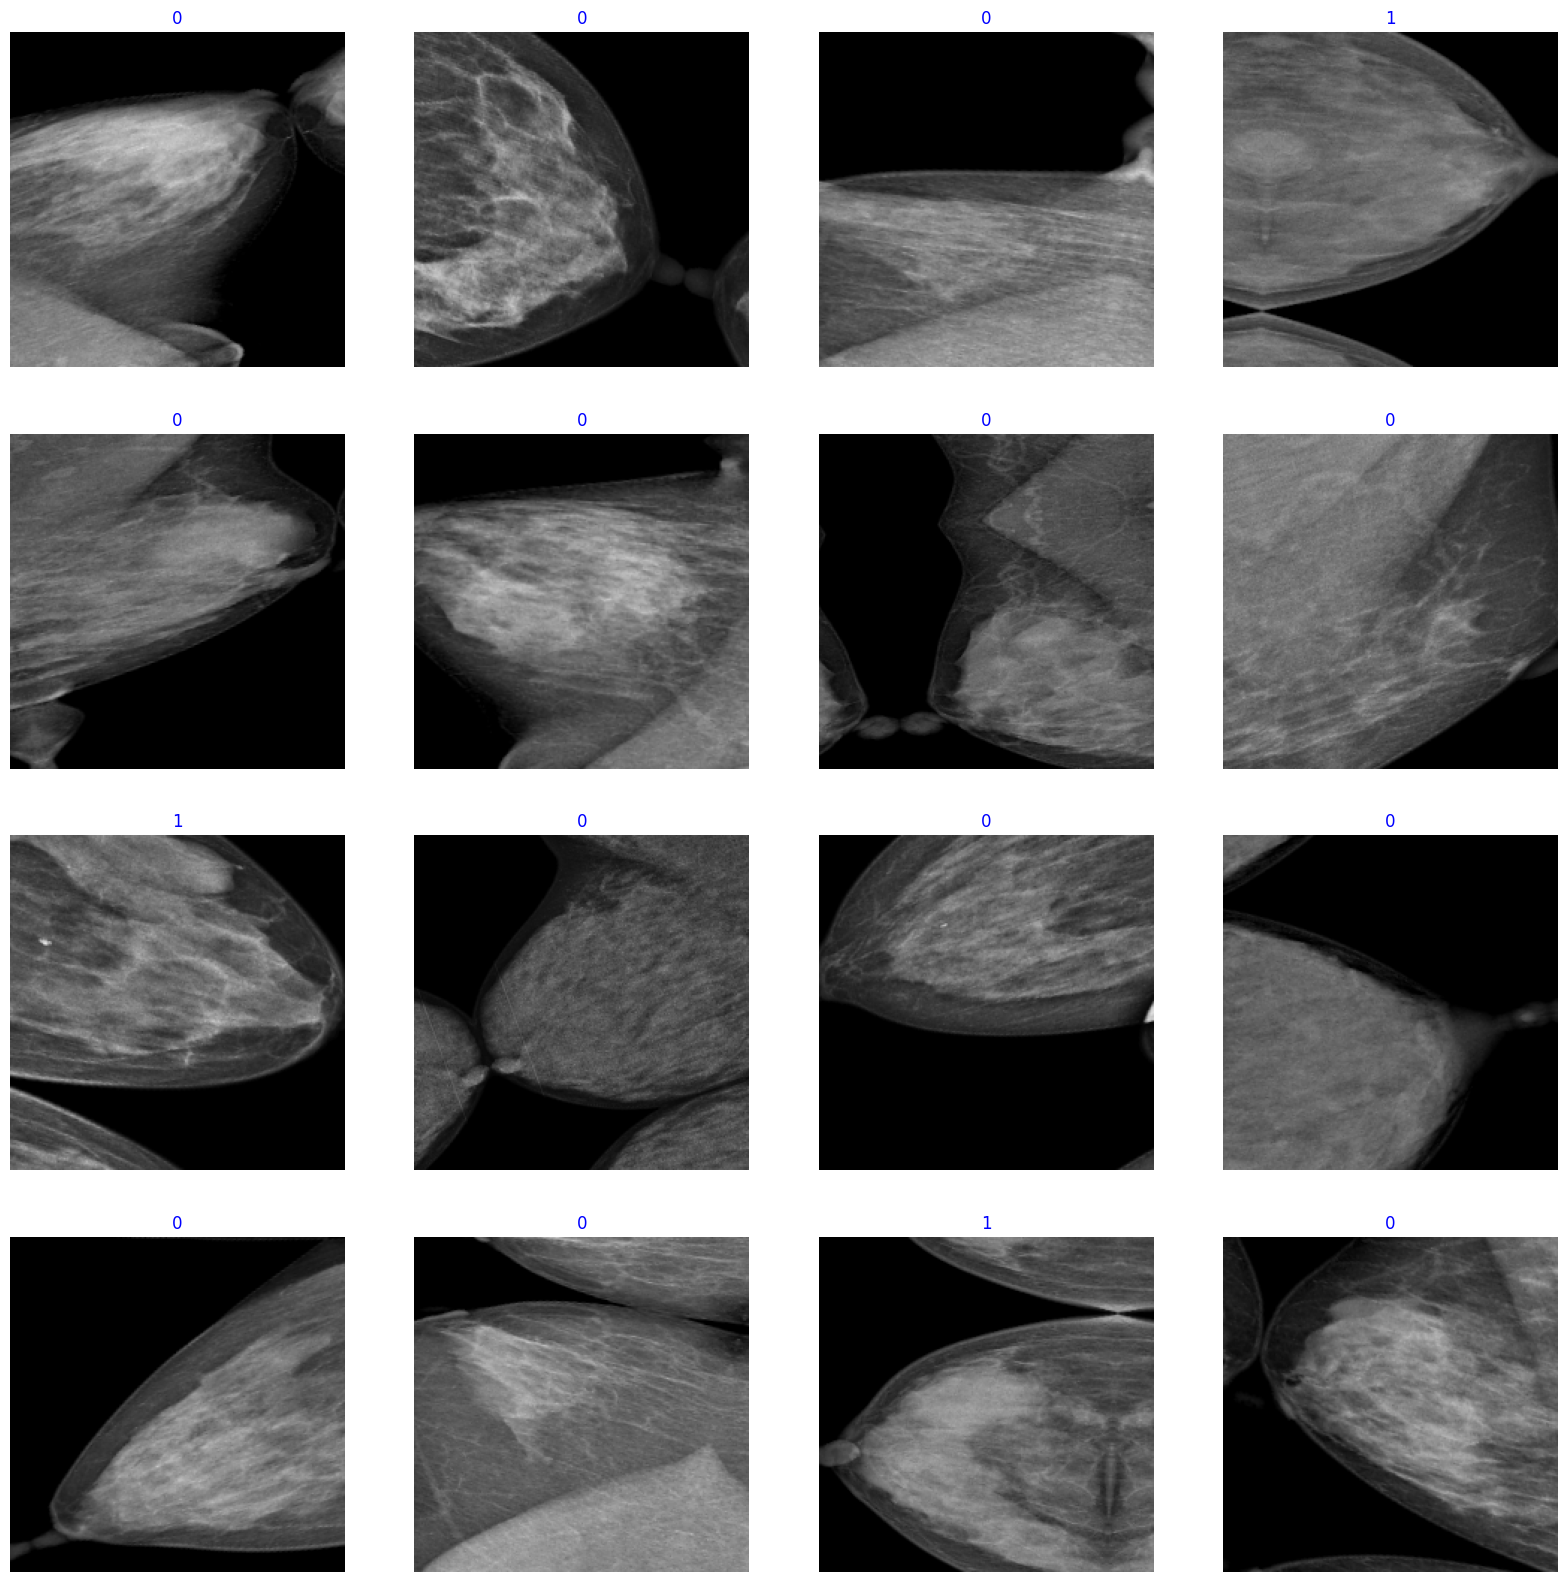

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] 
    plt.imshow(image)
    
    class_index = int(labels[i]) 
    class_name = classes[class_index]
    
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

## Model 

In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
lr = 0.001

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False,
                                                                    weights="imagenet",
                                                                    input_shape=img_shape, 
                                                                    pooling='avg')

model = Sequential([
    base_model,
#     BatchNormalization(),
#     Dense(2048, kernel_regularizer=regularizers.l2(0.02),
#                activity_regularizer=regularizers.l1(0.006),
#                bias_regularizer=regularizers.l1(0.006), activation='relu'),
#     Dropout(rate=0.45),
#     BatchNormalization(),
#     Dense(1024, kernel_regularizer=regularizers.l2(0.016),
#                activity_regularizer=regularizers.l1(0.006),
#                bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dense(1, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics= [ 
#                         tf.keras.metrics.TruePositives(name='TP'),
#                         tf.keras.metrics.FalsePositives(name='FP'),
#                         tf.keras.metrics.TrueNegatives(name='TN'),
#                         tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(curve='ROC', name='auc'),
                        tf.keras.metrics.AUC(curve='PR', name='pr_auc'), 
                        tf.keras.metrics.F1Score(average='macro', name='f1_score'),
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       ])

model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5920593 (22.59 MB)
Trainable params: 5859985 (22.35 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [13]:
import os
output_dir = '/kaggle/working/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

class CustomLRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, factor, step_size):
        super(CustomLRScheduler, self).__init__()
        self.lr = initial_lr
        self.factor = factor
        self.step_size = step_size
        self.epoch_count = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if self.epoch_count % self.step_size == 0:
            self.lr *= self.factor
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
        print(f'\nEpoch {epoch+1} - Learning Rate: {self.lr:.5f}')
        
initial_lr = lr
factor = 0.1
step_size = 5        
lr_scheduler = CustomLRScheduler(initial_lr, factor, step_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

ori_class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
malignant_weight = ori_class_weights[1]*2
class_weights = compute_class_weight({0:0.55302088, 1:malignant_weight}, 
                                     classes=np.unique(train_gen.classes), 
                                     y=train_gen.classes)
print(ori_class_weights)
print(class_weights)

[0.55302088 5.21512386]
[ 0.55302088 10.43024772]


In [15]:
epochs = 10
history = model.fit(train_gen, epochs=epochs, verbose=1,
                    validation_data= valid_gen,
                    validation_steps=None, shuffle=False,
                    class_weight=dict(enumerate(class_weights)),
                    callbacks=[early_stopping]
                    )

Epoch 1/10


2024-03-23 07:42:52.380360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711179785.472055      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 867s 7s/step - loss: 0.9758 - precision: 0.0957 - recall: 0.9492 - auc: 0.5147 - pr_auc: 0.1002 - f1_score: 0.1750 - accuracy: 0.1351 - val_loss: 0.8625 - val_precision: 0.0961 - val_recall: 1.0000 - val_auc: 0.4475 - val_pr_auc: 0.0832 - val_f1_score: 0.1752 - val_accuracy: 0.0970
Epoch 2/10
125/125 [==============================] - 589s 5s/step - loss: 0.9511 - precision: 0.0971 - recall: 0.9889 - auc: 0.5569 - pr_auc: 0.1235 - f1_score: 0.1750 - accuracy: 0.1173 - val_loss: 1.0680 - val_precision: 0.0960 - val_recall: 1.0000 - val_auc: 0.5001 - val_pr_auc: 0.0958 - val_f1_score: 0.1752 - val_accuracy: 0.0960
Epoch 3/10
125/125 [==============================] - 592s 5s/step - loss: 0.9058 - precision: 0.0984 - recall: 0.9713 - auc: 0.6415 - pr_auc: 0.2098 - f1_score: 0.1750 - accuracy: 0.1443 - val_loss: 0.7905 - val_precision: 0.0960 - val_recall: 1.0000 - val_auc: 0.5081 - val_pr_auc: 0.0937 - val_f1_score: 0.1752 - val_accuracy: 0.0960


In [16]:
model.save_weights(f'{output_dir}/model_weights.h5')
val_df.to_csv(f'{output_dir}/val_df.csv')
test_df.to_csv(f'{output_dir}/test_df.csv')

## Visualize model training process

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']

precision = history.history['precision']
val_precision = history.history['val_precision']

f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

auc = history.history['auc']
val_auc = history.history['val_auc']

prauc = history.history['pr_auc']
val_prauc = history.history['val_pr_auc']

epochs = range(len(recall))

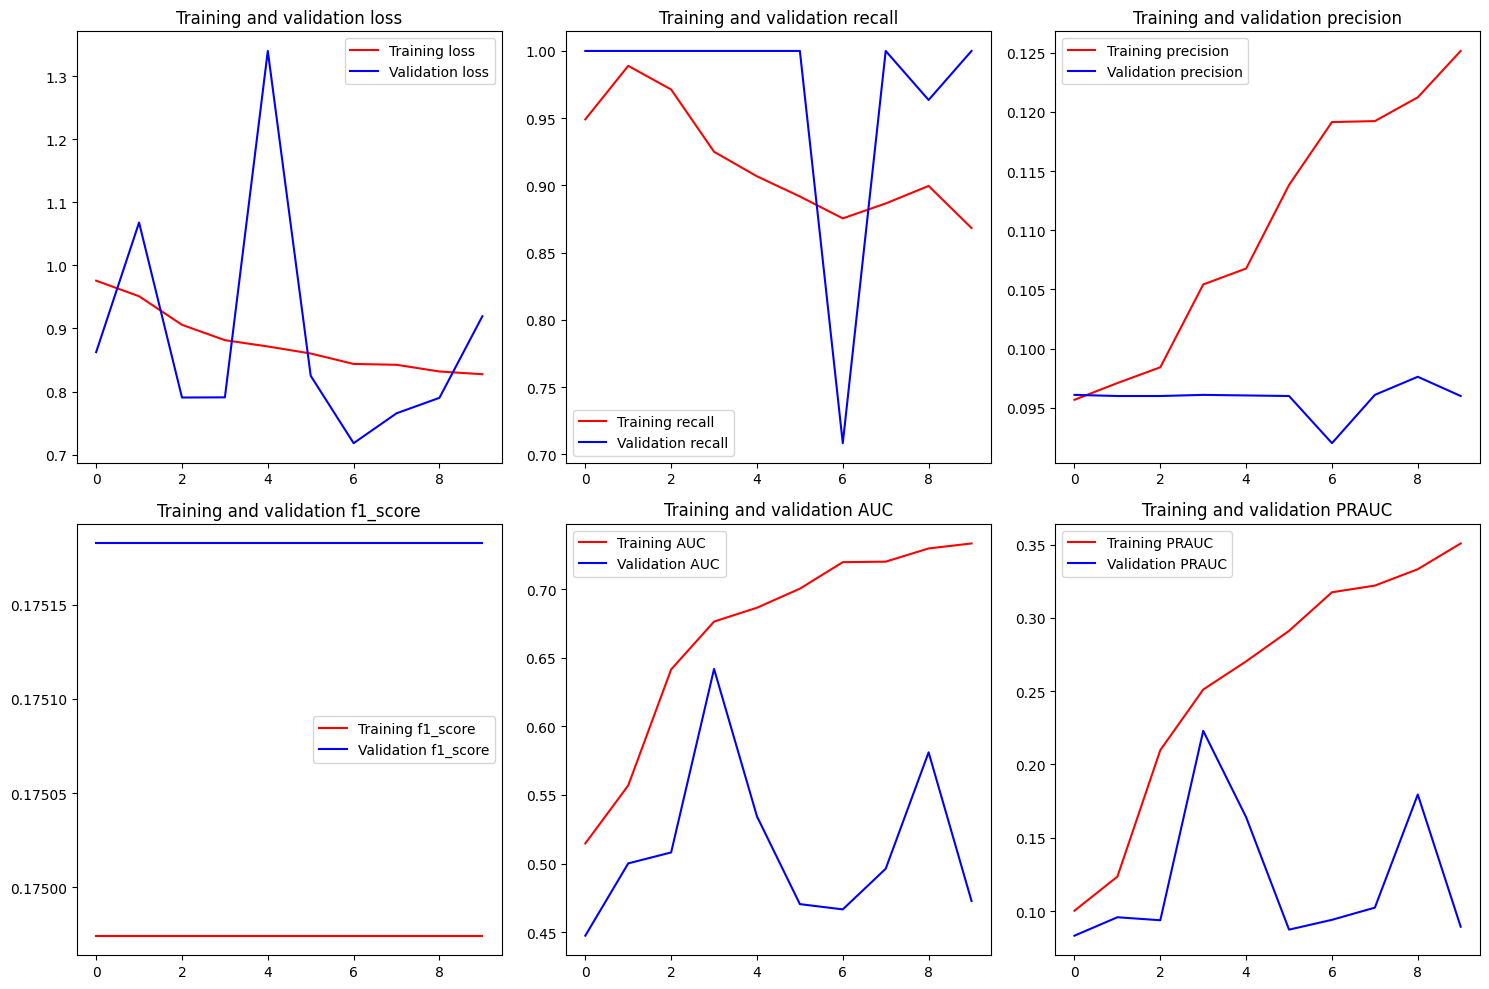

In [18]:
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting 
axs[0, 0].plot(epochs, loss, 'r', label='Training loss')
axs[0, 0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0, 0].set_title('Training and validation loss')
axs[0, 0].legend(loc=0)

axs[0, 1].plot(epochs, recall, 'r', label='Training recall')
axs[0, 1].plot(epochs, val_recall, 'b', label='Validation recall')
axs[0, 1].set_title('Training and validation recall')
axs[0, 1].legend(loc=0)

axs[0, 2].plot(epochs, precision, 'r', label='Training precision')
axs[0, 2].plot(epochs, val_precision, 'b', label='Validation precision')
axs[0, 2].set_title('Training and validation precision')
axs[0, 2].legend(loc=0)
# Hide the empty subplot
# axs[0, 2].axis('off')

axs[1, 0].plot(epochs, f1_score, 'r', label='Training f1_score')
axs[1, 0].plot(epochs, val_f1_score, 'b', label='Validation f1_score')
axs[1, 0].set_title('Training and validation f1_score')
axs[1, 0].legend(loc=0)
# axs[1, 0].axis('off')

axs[1, 1].plot(epochs, auc, 'r', label='Training AUC')
axs[1, 1].plot(epochs, val_auc, 'b', label='Validation AUC')
axs[1, 1].set_title('Training and validation AUC')
axs[1, 1].legend(loc=0)
# axs[1, 1].axis('off')

axs[1, 2].plot(epochs, prauc, 'r', label='Training PRAUC')
axs[1, 2].plot(epochs, val_prauc, 'b', label='Validation PRAUC')
axs[1, 2].set_title('Training and validation PRAUC')
axs[1, 2].legend(loc=0)
# Hide the empty subplot
# axs[1, 2].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Evaluate model

In [19]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

25/25 [==============================] - 83s 3s/step - loss: 0.9184 - precision: 0.0960 - recall: 1.0000 - auc: 0.4760 - pr_auc: 0.0931 - f1_score: 0.1752 - accuracy: 0.0960


## Get Predictions

In [20]:
preds = model.predict(test_gen)
# y_pred = np.argmax(preds, axis=1)
# y_pred = (preds >= 0.6).astype(np.int32)[:,0]
# y_true = test_gen.classes
print(preds)

25/25 [==============================] - 53s 2s/step
[[0.6258189 ]
 [0.6433487 ]
 [0.62070537]
 ...
 [0.6069995 ]
 [0.60575783]
 [0.6031089 ]]


In [21]:
y_pred = (preds >= 0.57).astype(np.int32)[:,0]
y_true = test_gen.classes
print(y_pred)

[1 1 1 ... 1 1 1]


In [22]:
# Save model predction to csv
# Get filenames from the test generator
filenames = test_gen.filenames

# Assuming y_pred is the predicted class (use argmax to get class labels)
y_pred_class = y_pred

# Create a DataFrame with predictions, true labels, and predicted probabilities for each class
results = pd.DataFrame({
    "img_path": filenames,
    "true_class": y_true,
    "predicted_class": y_pred_class,
    "prob": preds[:, 0],  # Probability
})

# Save the DataFrame to a CSV file
results.to_csv(f"{output_dir}/prediction_result.csv", index=False)
results

,img_path,true_class,predicted_class,prob
0,/kaggle/input/full-fullsize/png/png/b2979c0f7f...,1,1,0.625819
1,/kaggle/input/full-fullsize/png/png/d0322ac757...,0,1,0.643349
2,/kaggle/input/full-fullsize/png/png/1fe77db1e4...,0,1,0.620705
3,/kaggle/input/full-fullsize/png/png/2db80265d2...,0,1,0.633467
4,/kaggle/input/full-fullsize/png/png/d90bbc67c7...,0,1,0.582553
...,...,...,...,...
1995,/kaggle/input/full-fullsize/png/png/4f2dbafc34...,0,1,0.580708
1996,/kaggle/input/full-fullsize/png/png/9b7e001b3a...,0,1,0.640687
1997,/kaggle/input/full-fullsize/png/png/fbc135926b...,0,1,0.607000
1998,/kaggle/input/full-fullsize/png/png/80c50f0ade...,0,1,0.605758


### Confusion Matrics and Classification Report

In [23]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.80      0.00      0.01      1808
           1       0.10      0.99      0.17       192

    accuracy                           0.10      2000
   macro avg       0.45      0.50      0.09      2000
weighted avg       0.73      0.10      0.02      2000



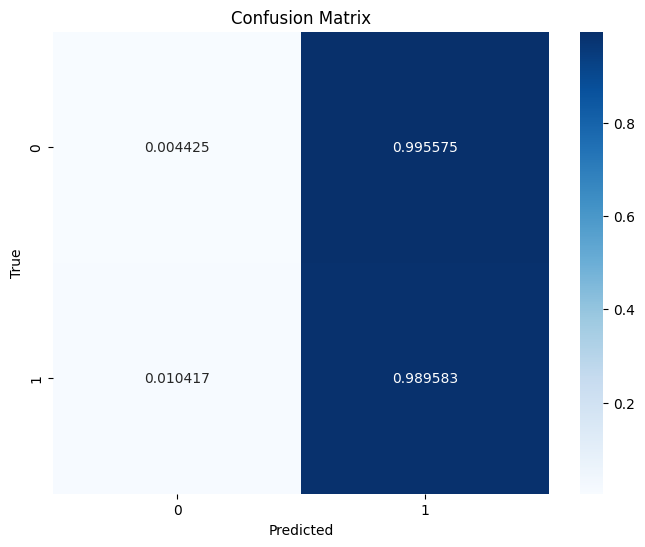

In [24]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Assuming y_true and y_pred are your true labels and predicted labels
# and conf_matrix is your confusion matrix

print("F1 Score: {:.4f}".format(f1_score(y_true, y_pred, average='macro')))
print("Recall score: {:.4f}".format(recall_score(y_true, y_pred, average='macro')))
print("Precision score: {:.4f}".format(precision_score(y_true, y_pred, average='macro')))

# Calculate AUC
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc:.4f}")

# Calculate PRAUC
pr_auc = average_precision_score(y_true, y_pred)
print(f"PRAUC: {pr_auc:.4f}")

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")

F1 Score: 0.0915
Recall score: 0.4970
Precision score: 0.4477
AUC: 0.4970
PRAUC: 0.0955
Sensitivity (True Positive Rate): 0.9896
Specificity (True Negative Rate): 0.0044


### ROC

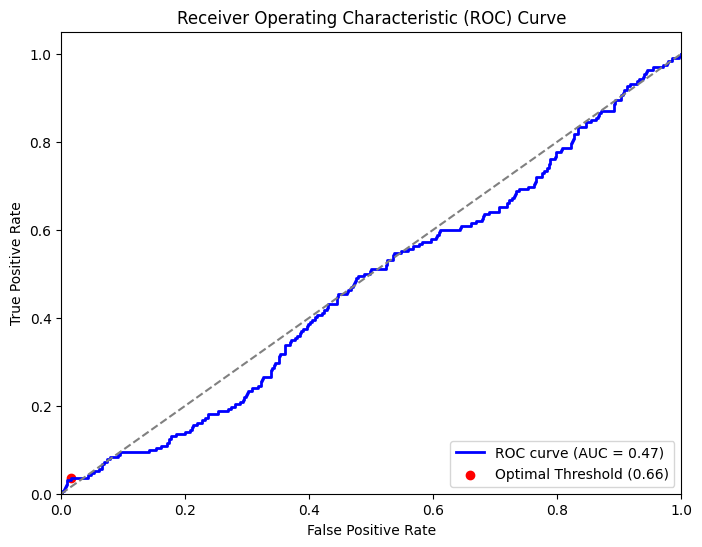

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, preds[:, 0])

# Calculate AUC score
auc = roc_auc_score(y_true, preds[:, 0])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], marker='o', color='red', 
            label=f'Optimal Threshold ({thresholds[np.argmax(tpr - fpr)]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### PR Curve

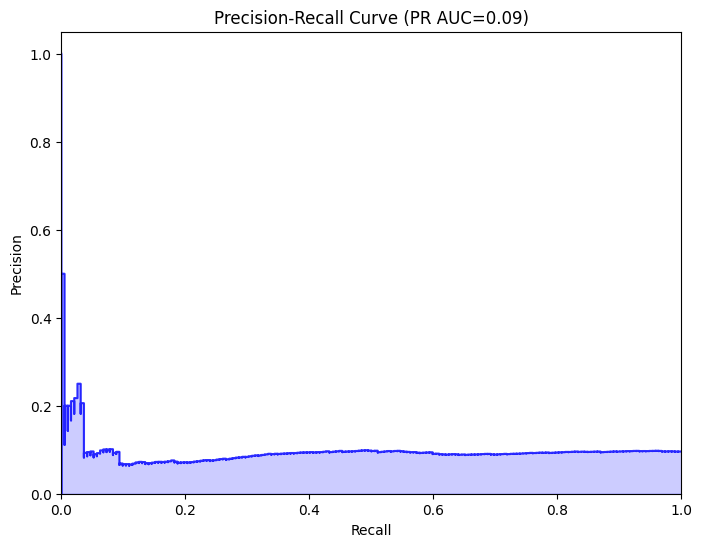

In [27]:
from sklearn.metrics import auc, precision_recall_curve, f1_score, average_precision_score

# Make predictions on the test data
y_scores = preds[:, 0]

# y_scores = y_scores[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)  # Assuming binary classification, use y_scores[:, 1]

# Calculate AUC for precision-recall curve
pr_auc = auc(recall, precision)

# Alternatively, you can use tf.keras.metrics.AUC directly
pr_auc_metric = tf.keras.metrics.AUC(curve='PR')
pr_auc_metric.update_state(y_true, y_scores)  # Assuming binary classification, use y_scores[:, 1]
pr_auc = pr_auc_metric.result().numpy()

# Visualize the PR curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (PR AUC={pr_auc:0.2f})')
plt.show()

## **Incorrect predictions**

In [28]:
incorrect_predictions = results[results['true_class'] != results['predicted_class']]
incorrect_predictions

,img_path,true_class,predicted_class,prob
1,/kaggle/input/full-fullsize/png/png/d0322ac757...,0,1,0.643349
2,/kaggle/input/full-fullsize/png/png/1fe77db1e4...,0,1,0.620705
3,/kaggle/input/full-fullsize/png/png/2db80265d2...,0,1,0.633467
4,/kaggle/input/full-fullsize/png/png/d90bbc67c7...,0,1,0.582553
5,/kaggle/input/full-fullsize/png/png/3780f3f82e...,0,1,0.646493
...,...,...,...,...
1994,/kaggle/input/full-fullsize/png/png/07e80ff594...,0,1,0.602706
1995,/kaggle/input/full-fullsize/png/png/4f2dbafc34...,0,1,0.580708
1996,/kaggle/input/full-fullsize/png/png/9b7e001b3a...,0,1,0.640687
1997,/kaggle/input/full-fullsize/png/png/fbc135926b...,0,1,0.607000


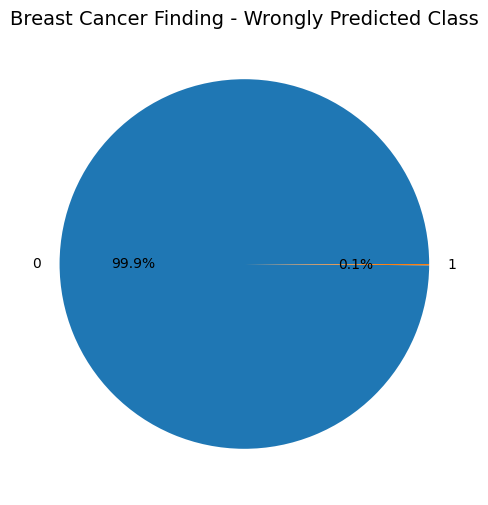

In [29]:
value = incorrect_predictions['true_class'].value_counts()
plt.figure(figsize=(8, 6))
plt.title('Breast Cancer Finding - Wrongly Predicted Class', fontsize=14)
plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.show()

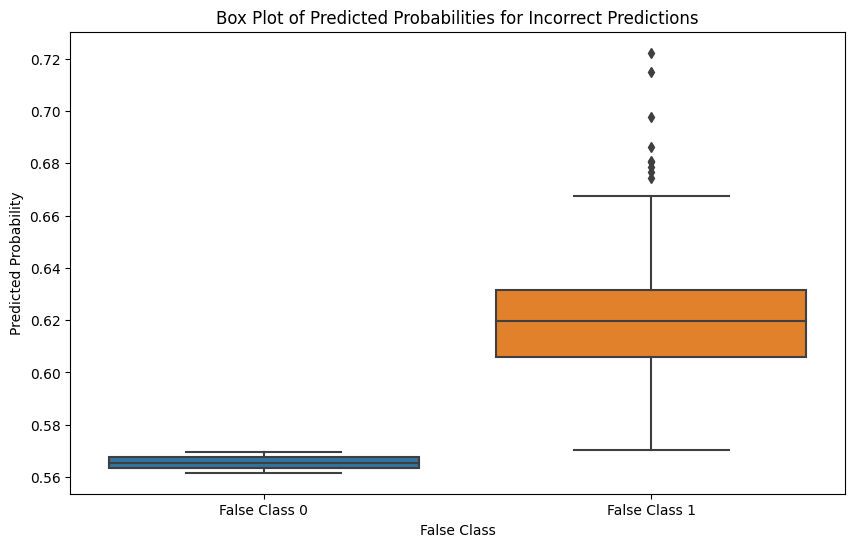

In [30]:
# Combine the predicted probabilities into a single DataFrame
probs_df =  pd.DataFrame({
    'False Class 0': incorrect_predictions.loc[incorrect_predictions['predicted_class'] == 0, 'prob'],
    'False Class 1': incorrect_predictions.loc[incorrect_predictions['predicted_class'] == 1, 'prob'],
})

# Box plot to compare the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.boxplot(data=probs_df)
plt.title('Box Plot of Predicted Probabilities for Incorrect Predictions')
plt.xlabel('False Class')
plt.ylabel('Predicted Probability')
plt.show()